In [101]:
import pandas as pd
import numpy as np
import sklearn

In [366]:
netflix_titles = pd.read_csv('../data/final_data/complete_manually_cleaned_data.csv')

In [103]:
ratings = pd.read_csv('../data/external/title.ratings.tsv', sep='\t')

basics = pd.read_csv('../data/external/title.basics.tsv', sep='\t', usecols=['tconst', 'titleType', 'runtimeMinutes', 'genres'])

In [367]:
df = netflix_titles.merge(ratings, how='left', on='tconst').merge(basics, how='left', on='tconst')

In [118]:
# df.loc[(~df['is_tv_show']) & df['titleType'].isin(['tvMiniSeries', 'tvSeries']), 'season'] = accidental_tv_show_in_movie['combined_title'].str.extract(r' (\d+)', expand=False).fillna(1)
# df.loc[df['season'].notnull(), 'is_tv_show'] = True

ValueError: Must have equal len keys and value when setting with an iterable

In [368]:
#Lets also combine movie with tvMovie and short with Tvshort
df.loc[df['titleType'] == 'tvMovie', 'titleType'] = 'movie'
df.loc[df['titleType'] == 'tvShort', 'titleType'] = 'short'

#Waffles + Mochi's Holiday Feast is a holiday special of a tv show, let's label it as a tvSpecial
df.loc[df['combined_title'] == 'Waffles + Mochi\'s Holiday Feast', 'titleType'] = 'tvSpecial'


In [369]:
df[(~df['is_tv_show'])]['titleType'].value_counts()

movie        742
tvSpecial    130
short         45
Name: titleType, dtype: int64

In [370]:
#My Wonderful Life Manually added data

df.loc[df['combined_title']=='My Wonderful Life', 'averageRating'] = 5.9
df.loc[df['combined_title']=='My Wonderful Life', 'numVotes'] = 714
df.loc[df['combined_title']=='My Wonderful Life', 'titleType'] = 'movie'
df.loc[df['combined_title']=='My Wonderful Life', 'runtimeMinutes'] = 99
df.loc[df['combined_title']=='My Wonderful Life', 'genres'] = 'Comedy,Drama,Romance'

In [371]:
#df.to_csv('../data/interim/merged_data.csv', index=False)

In [372]:
#removes the storybot shorts and The New which have no data on imdb
df = df[df['averageRating'].notnull()].copy()

In [373]:
#Top 10 to int
df['is_top10'] = df['is_top10'].astype(int)

#Replace \N with NaN
df.replace('\\N', np.nan, inplace=True)

## A little feature engineering with release date

In [374]:
# Turn release date into datetime
df['release_date'] = pd.to_datetime(df['release_date'], format='%Y%m%d')

# Add month, week, quarter
df['release_date_quarter'] = df['release_date'].dt.quarter
df['release_date_month'] = df['release_date'].dt.month
df['release_date_week'] = df['release_date'].dt.isocalendar().week

## Create features with movie summary

In [383]:
summaries = pd.read_csv('../data/interim/GlobalOriginalsWithSummary.csv')

In [390]:
df = pd.merge(df, summaries[['combined_title', 'summary']], on='combined_title')

## Actor/Director Rankings

In [392]:
people_rankings = pd.read_csv('../data/interim/showsWithPrinicpalRankings.csv')

In [393]:
people_rankings

,combined_title,release_year,release_date,is_top10,title,season,is_tv_show,tconst,averageRating,numVotes,titleType,runtimeMinutes,genres,director_rank,writer_rank,actor_rank
0,Titans: Season 3,2021,20210812,True,titans,3.0,True,tt1043813,7.6,98482.0,tvSeries,45,"Action,Adventure,Crime",58.0,22.666667,2254.000000
1,Star Trek: Discovery: Season 3,2020,20201015,False,star trek discovery,3.0,True,tt5171438,7.0,122274.0,tvSeries,60,"Action,Adventure,Drama",119.0,36.333333,1648.333333
2,Star Trek: Discovery: Season 4,2021,20211118,False,star trek discovery,4.0,True,tt5171438,7.0,122274.0,tvSeries,60,"Action,Adventure,Drama",119.0,36.333333,1648.333333
3,Interceptor,2022,20220603,True,interceptor,NaN,False,tt14174940,4.5,22470.0,movie,99,"Action,Adventure,Drama",NaN,46.000000,11152.666670
4,Jurassic World Camp Cretaceous: Season 1,2020,20200918,True,jurassic world camp cretaceous,1.0,True,tt10436228,7.5,8798.0,tvSeries,24,"Action,Adventure,Animation",1766.0,55.000000,1541.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,Yuri Marçal: Honest Mistake,2022,20220602,False,yuri marçal honest mistake,NaN,False,tt20597344,6.5,46.0,tvSpecial,59,"Comedy,Documentary",71245.5,NaN,168717.000000
2222,Zero to Hero,2021,20211105,True,zero to hero,NaN,False,tt14892216,6.7,925.0,movie,102,"Biography,Drama,Sport",55914.5,NaN,19532.166670
2223,"ariana grande: excuse me, i love you",2020,20201221,False,ariana grande excuse me i love you,NaN,False,tt13615386,6.3,2648.0,movie,97,"Documentary,Music",5695.0,NaN,47846.666670
2224,jeen-yuhs: A Kanye Trilogy,2022,20220216,True,jeenyuhs a kanye trilogy,1.0,True,tt14599438,8.0,9043.0,tvMiniSeries,90,"Documentary,Music",17577.5,NaN,20629.166670


## Split the data into train and test sets

In [ ]:
#Split movie and tv_show
movies, tv_shows = df[df['is_tv_show']==False], df[df['is_tv_show']==True]

## Movies

In [134]:
# drop columns that are not needed
movies = movies.drop(['tconst', 'combined_title', 'title', 'season', 'is_tv_show'], axis = 1)

In [322]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movies.drop('is_top10', axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])


Let's first verify that the test and train sets are balanced

In [324]:
#Compare train and test set y distribution

print('Train set distribution')
print(y_train.value_counts(normalize=True))
print('Test set distribution')
print(y_test.value_counts(normalize=True))

Train set distribution
1    0.521146
0    0.478854
Name: is_top10, dtype: float64
Test set distribution
1    0.521739
0    0.478261
Name: is_top10, dtype: float64


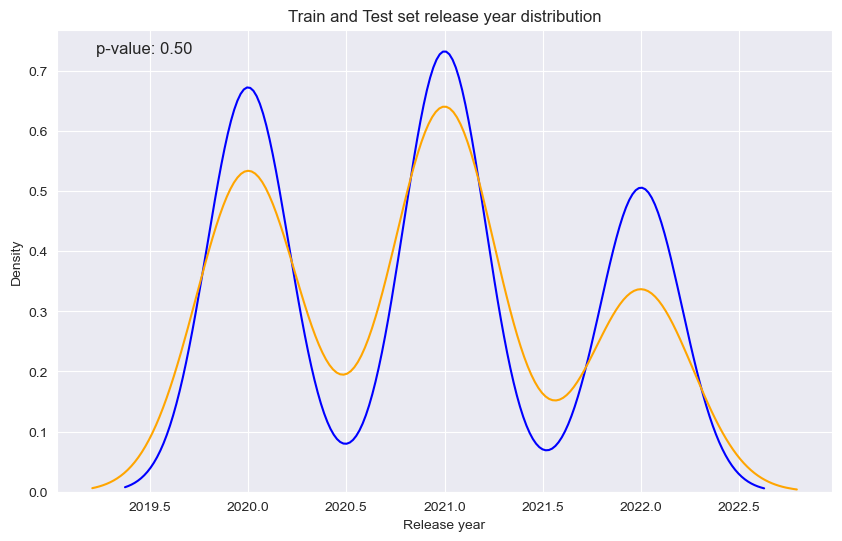

In [325]:
#Make sure the train and test set release year distribution is not statistically different

from scipy.stats import ttest_ind

ttest_ind(X_train['release_year'], X_test['release_year'])

#Now plot it

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['release_year'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['release_year'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set release year distribution')
ax.set_xlabel('Release year')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["release_year"], X_test["release_year"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()


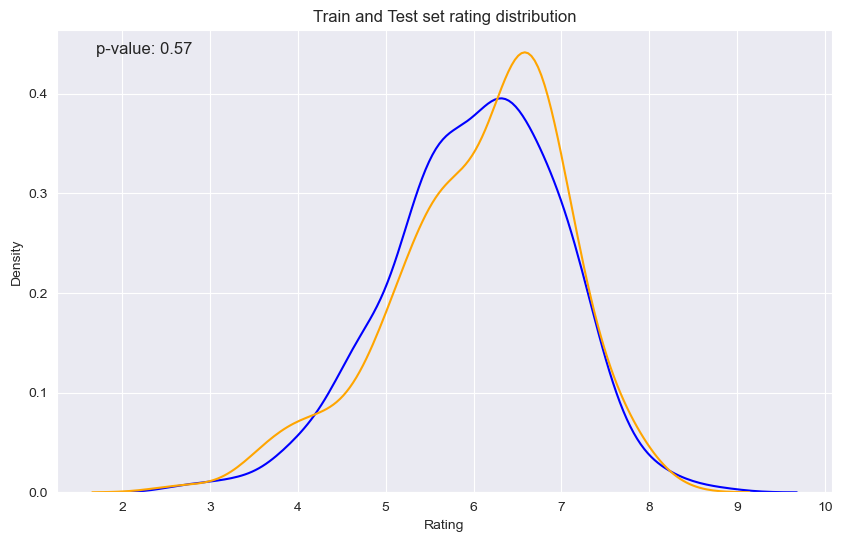

In [326]:
#Plot and compare the train and test set rating distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['averageRating'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['averageRating'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set rating distribution')
ax.set_xlabel('Rating')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["averageRating"], X_test["averageRating"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

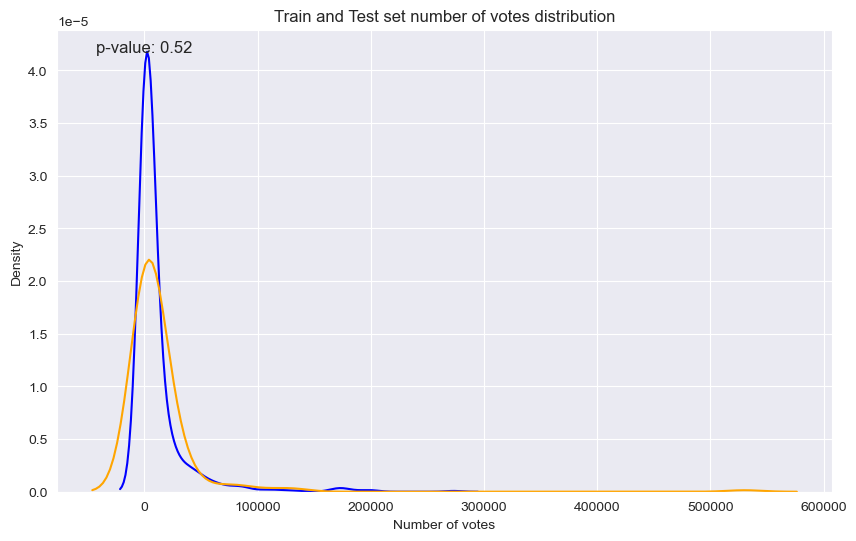

In [327]:
# Plot and compare the train and test set number of votes distribution

fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(X_train['numVotes'], ax=ax, color='blue', label='Train')
sns.kdeplot(X_test['numVotes'], ax=ax, color='orange', label='Test')
ax.set_title('Train and Test set number of votes distribution')
ax.set_xlabel('Number of votes')
ax.set_ylabel('Density')
ax.annotate(f'p-value: {ttest_ind(X_train["numVotes"], X_test["numVotes"])[1]:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

Bag of Words for Genres

In [312]:
from sklearn.feature_extraction.text import CountVectorizer

#Create a count vectorizer to count the number of words in the genres column
count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.99, binary=True, token_pattern=r'(?u)[a-zA-Z][a-z -]+')
count_vectorizer.fit(X_train['genres'])

CountVectorizer(binary=True, max_df=0.99, min_df=0.05,
                token_pattern='(?u)[a-zA-Z][a-z -]+')

In [313]:
#Transform the genres column
genres_train = count_vectorizer.transform(X_train['genres'])
#Convert to a dataframe
genres_train = pd.DataFrame(genres_train.todense(), columns=count_vectorizer.get_feature_names_out())

#Transform the genres column
genres_test = count_vectorizer.transform(X_test['genres'])
#Convert to a dataframe
genres_test = pd.DataFrame(genres_test.todense(), columns=count_vectorizer.get_feature_names_out())

In [314]:
train_genres_temp = pd.DataFrame({"percent_counts": genres_train.sum()/genres_train.sum().sum(), "type": "train"}).reset_index()
test_genres_temp = pd.DataFrame({"percent_counts": genres_test.sum()/genres_test.sum().sum(), "type": "test"}).reset_index()

genres_temp = pd.concat([train_genres_temp, test_genres_temp], axis=0)

Text(0.05, 0.95, 'chi2-value: 0.74')

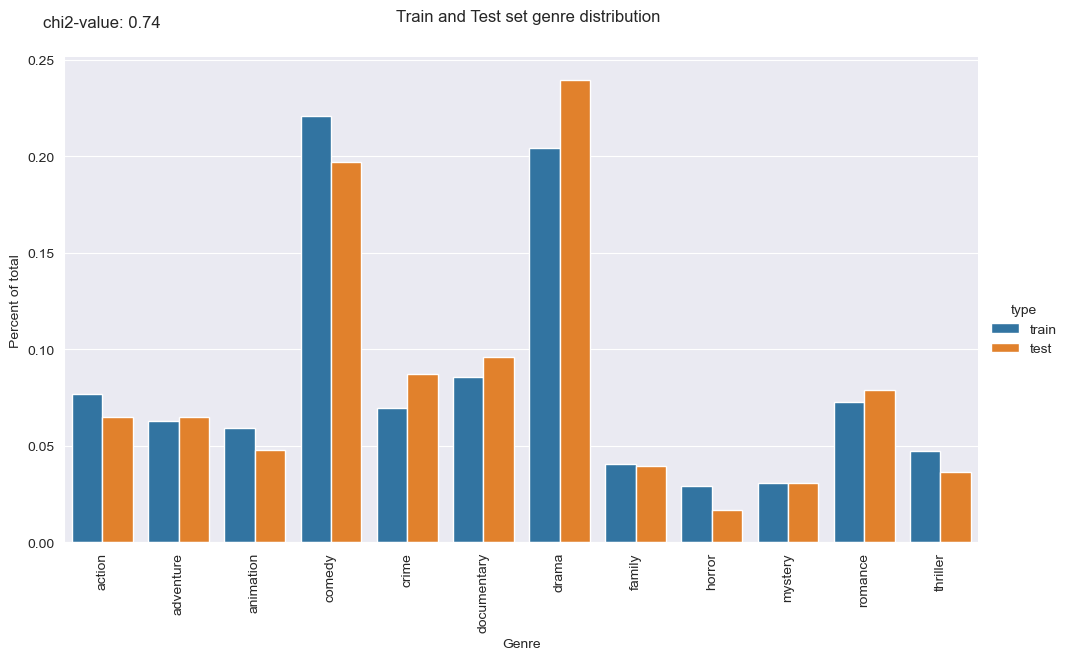

In [315]:
#plot the train and test set genre distributions with offset to see if they are similar

ax = sns.catplot(y='percent_counts', x='index', hue='type', data=genres_temp, kind='bar', height=6, aspect=10/6)

ax.set_xticklabels(rotation=90)

#annotate a chi square test to see if the distributions are statistically different

from scipy.stats import chi2_contingency

chi2_contingency([genres_train.sum(), genres_test.sum()])
ax.set_axis_labels('Genre', 'Percent of total')
ax.fig.suptitle('Train and Test set genre distribution')
ax.fig.subplots_adjust(top=0.9)
ax.fig.text(0.05, 0.95, f'chi2-value: {chi2_contingency([genres_train.sum(), genres_test.sum()])[1]:.2f}', fontsize=12)

In [328]:
# Now add the genres to the train and test set

X_train = pd.concat([X_train, genres_train], axis=1)
X_test = pd.concat([X_test, genres_test], axis=1)

Everything looks good! Next step:

## Fill Blanks

In [332]:
from sklearn.impute import SimpleImputer

#Create a simple imputer to fill in the missing values with the mean
imputer = SimpleImputer(strategy='mean')

#Fit the imputer to the train set
imputer.fit(X_train[['runtimeMinutes']])
#Transform the train set
X_train['runtimeMinutes'] = imputer.transform(X_train[['runtimeMinutes']])
#Transform the test set
X_test['runtimeMinutes'] = imputer.transform(X_test[['runtimeMinutes']])
#Check the results
X_train['runtimeMinutes'].isna().sum()

0

### Feature Engineering on the release date


In [336]:
#Create features from release date

df['release_date']

0       20200417
1       20200812
2       20201204
3       20200313
4       20211224
          ...   
2221    20220216
2222    20200124
2223    20211119
2224    20201002
2225    20200123
Name: release_date, Length: 2222, dtype: int64

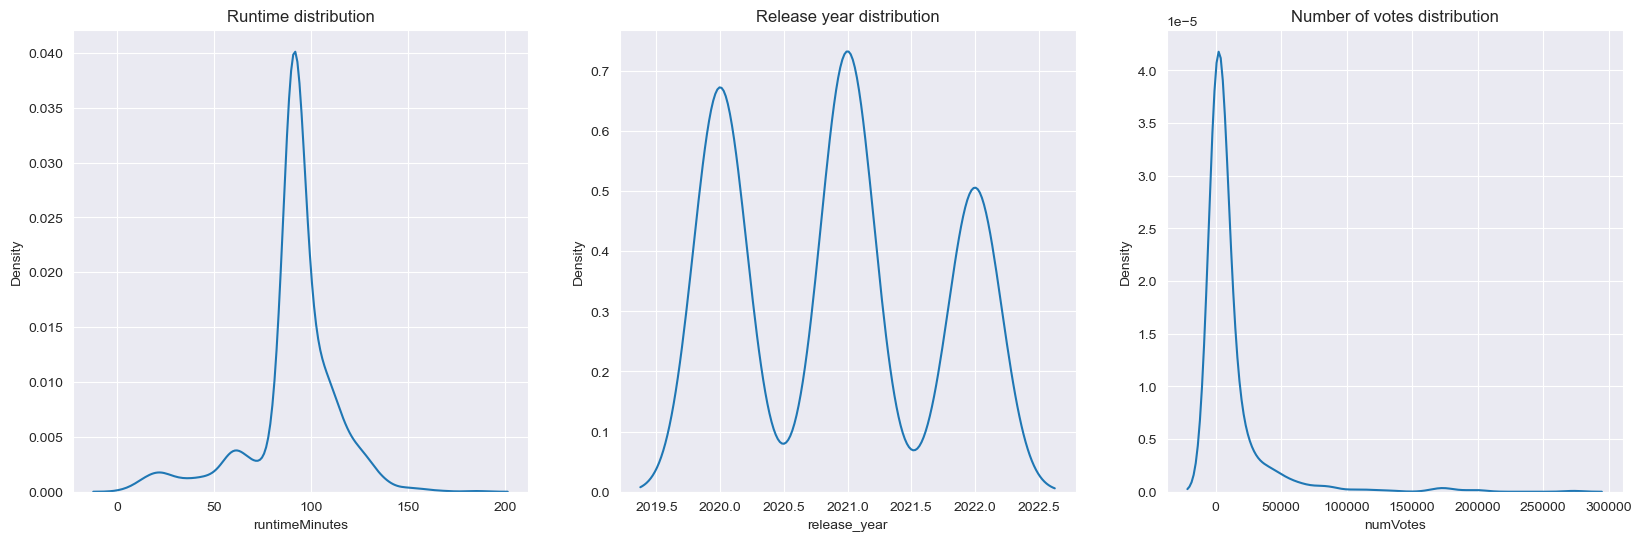

In [333]:
#Check distribution of the train set features

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.kdeplot(X_train['runtimeMinutes'], ax=ax[0])
sns.kdeplot(X_train['numVotes'], ax=ax[1])
ax[0].set_title('Runtime distribution')
ax[2].set_title('Number of votes distribution')
plt.show()

In [155]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer

In [156]:
transformer = ColumnTransformer(
    [("onehot",OneHotEncoder(drop='first', handle_unknown='ignore'), ['titleType']),
    ("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
    ("bagofw", CountVectorizer(), 'genres')
    ],
    remainder='passthrough')

In [158]:
from sklearn.pipeline import Pipeline

In [159]:
from sklearn.feature_selection import SelectFromModel

In [160]:
#make sklearn pipeline with transform, normalization, and model
pipe = Pipeline(
    steps=[
        ('transformer', transformer),
        ('normalizer', sklearn.preprocessing.Normalizer()),
        ('standardizer', sklearn.preprocessing.StandardScaler(with_mean=False)),
        #('feature_selection', SelectFromModel(sklearn.linear_model.LogisticRegression())),
        ('logistic_regress', sklearn.linear_model.LogisticRegression(max_iter = 1000))
        
    ]
)